In [1]:
import sys
sys.path.append('../modules')

from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2

In [2]:
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/hdd/*.nc'
#PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jul2.5p/*.nc'

In [3]:
#ds = read_data(PATH)

import xarray as xr

PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'

test_file = xr.open_dataset(PATH)
test_file = test_file.rename({'time':'run'})
ds = test_file.rename({'snw':'dv'})

dv_field = ds['dv'].values.copy()
ens = ens_flat(dv_field)
rlat, rlon = ds['rlat'].values, ds['rlon'].values

ValueError: cannot rename 'time' because it is not a variable or dimension in this dataset

In [ ]:
irlon = np.linspace(np.min(rlon), np.max(rlon), rlon.shape[0]*10)
irlat = np.linspace(np.min(rlat), np.max(rlat), rlat.shape[0]*10)

rlon_ens = np.tile(rlon, rlat.shape[0])
rlat_ens = np.repeat(rlat, rlon.shape[0])

irlon_ens = np.tile(irlon, irlat.shape[0])
irlat_ens = np.repeat(irlat, irlon.shape[0])
icoordens = np.array(list(zip(irlon_ens, irlat_ens)))

coordens = np.array(list(zip(rlon_ens, rlat_ens)))

In [ ]:
mask = load_land_mask('../data/mask.nc')
mask_master = mask_land_and_nan(dv_field, mask)
idx_ = mask_land_and_nan_ens_index(mask_master)
print(mask_master.shape)
#imask = np.tile(mask, (irlon.shape[0]*irlat.shape[0]))
mask_master = np.repeat(np.repeat(mask_master, 10, axis=1), 10) # honestly don't know how this works but it does
mask_master.shape
#idx = mask_land_and_nan_ens_index(mask_master)

In [ ]:
imask = np.expand_dims(np.reshape(mask_master, (irlat.shape[0], irlon.shape[0])), axis=0)
imask.shape
idx = mask_land_and_nan_ens_index(imask)
idx.shape, idx_.shape

In [ ]:
#fmask = interpolate.griddata(coordens, mask_master, icoordens, method = 'cubic', fill_value=False)

#imask = fmask.copy()
#imask = np.expand_dims(imask.astype(bool), axis=0)

#print(mask[0, ...].shape)

#plt.figure(figsize=(10, 10))
#plt.imshow(mask[0, ...], extent=[np.amin(rlon), np.amax(rlon), np.amin(rlat), np.amax(rlat)], cmap='cool', alpha=0.7)
#plt.imshow(imask, cmap='Greys', alpha=0.7)
#plt.gca().invert_yaxis()
#plt.savefig('/home/nannau/Desktop/maskpic.png')
#plt.show()

In [ ]:
#idx = imask == True
#idx.shape
points = icoordens[idx]

In [ ]:
iens = np.broadcast_to(np.reshape(imask, (irlon.shape[0]*irlat.shape[0])), (dv_field.shape[0], irlon.shape[0]*irlat.shape[0])).copy().astype(float)


In [10]:
points = icoordens[idx]

for i in range(dv_field.shape[0]):
    iens[i, idx] = interpolate.griddata(coordens[idx_], ens[i, idx_], points, method='linear')

iens.shape, ens.shape

((35, 2015000), (35, 20150))

In [77]:
nan_mask = np.apply_over_axes(
                np.logical_or.reduce,
                np.isnan(iens),
                (0)
)

master_idx = ~np.logical_or(~mask_master, nan_mask).flatten()

iens[:, master_idx]

NameError: name 'iens' is not defined

In [76]:
np.std(iens[:, master_idx], axis=1).shape

NameError: name 'iens' is not defined

In [12]:
area = frac_grid_area(irlon, irlat)
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape

(1, 2015000)

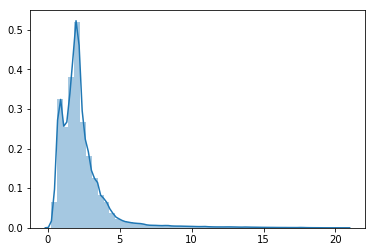

In [13]:
mean = iens.mean(axis=0)[master_idx].reshape(1, -1)
sns.distplot(mean.flatten())

In [40]:
corr_ens = (iens[:, master_idx] - mean)*area_relevent_grid_cells[:, master_idx]      
#corr_ens = corr_ens[:, master_idx]


In [42]:
model_eof = ens_to_eof(corr_ens.T, explained_variance=0.95)
#ens_eof = model_eof.components_

#corr_ens_full_size[:ens_eof.shape[0], idx] = ens_eof

print("EOF Shape: ", ens_eof.shape)

EOF Shape:  (28, 35)


In [43]:
#corr_ens.shape
X = model_eof.transform(corr_ens.T)
ens_eof = X.T

del corr_ens

In [44]:
#ens_eof = X.T
ens_eof.shape


(28, 628708)

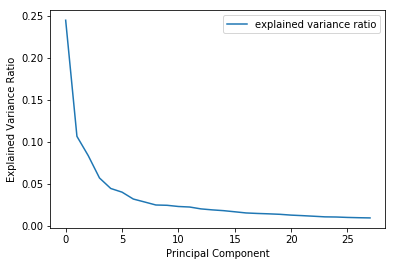

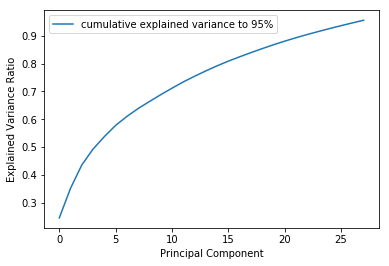

In [45]:
sns.lineplot(range(ens_eof.shape[0]), 
             model_eof.explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
sns.lineplot(range(ens_eof.shape[0]), 
             np.cumsum(model_eof.explained_variance_ratio_),
             label='cumulative explained variance to 95%')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [46]:
rcoord_ens_dict = rlat_rlon_to_ens(irlat, irlon)
rlat_ens = rcoord_ens_dict['rlat'][master_idx]
rlon_ens = rcoord_ens_dict['rlon'][master_idx]

lat_lon_ens = list(zip(rlat_ens, rlon_ens))
len(lat_lon_ens)

628708

In [47]:
df = pd.read_csv('/storage/data/projects/nrc/station_data/snow_load/swe_rl50_stations_test.csv', index_col=None)

In [48]:
#df = df[df['completeness'] > 0.8]
df.head()

,id,station_name,lat,lon,prov,snow_load_rl50
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342


In [49]:
lat_lon_obs = list(zip(df['lat'], df['lon']))
lat_obs, lon_obs = zip(*lat_lon_obs)

coords = to_rotated(lat_obs, lon_obs)
rlat_obs, rlon_obs = np.array(coords['rlat_obs']), np.array(coords['rlon_obs'])

lat_lon_obs = list(zip(rlat_obs, rlon_obs))

In [50]:
df['nearest_grid'] = dist_index(lat_lon_obs, lat_lon_ens)

In [51]:
ndf = df['snow_load_rl50'].groupby(df['nearest_grid']).max()


In [52]:
ndf.shape, df.shape

((525,), (526, 7))

In [53]:
match_ens_obs_idx = np.asarray(ndf.index)
mean[:, match_ens_obs_idx].shape

(1, 525)

In [54]:
match_obs_ens = (np.array(ndf)-mean[:, match_ens_obs_idx])*area_relevent_grid_cells[:, match_ens_obs_idx]
match_obs_ens2 = (np.array(ndf))*area_relevent_grid_cells[:, match_ens_obs_idx]

match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (28, 525) 
Matched Obs shape:  (525,)


In [55]:
from sklearn.neural_network import MLPRegressor

#model = MLPRegressor() 
model = regress_eof(match_model_ens.T, match_obs_ens.flatten())

Regressed model score: 0.60864011040018


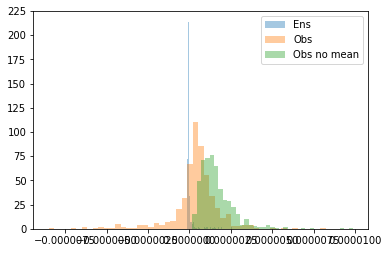

In [56]:
sns.distplot(match_model_ens[0, :], kde=False, label='Ens')
sns.distplot(match_obs_ens[0, :], kde=False, label='Obs')
sns.distplot(match_obs_ens2[0, :], kde=False, label='Obs no mean')

plt.legend()

In [57]:
predictions = predict_dv(model, ens_eof.T)

In [58]:
latlist, lonlist = zip(*list(lat_lon_ens))

In [1]:
observations = match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx]+mean[match_ens_obs_idx]
reconstructed_observations = predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx]+mean[match_ens_obs_idx]

NameError: name 'match_obs_ens' is not defined

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print("slope", regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('EOF Score', model.score(match_model_ens.T, match_obs_ens.flatten()))


slope 0.6077957880130632
EOF Score 0.60864011040018


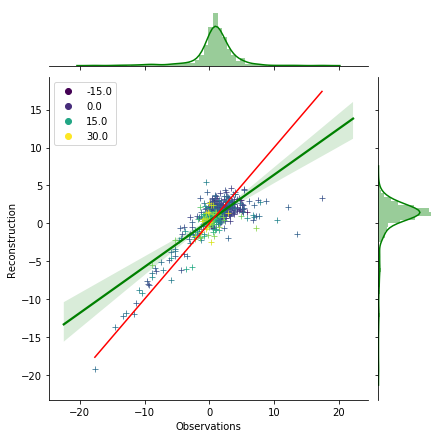

In [64]:
ax = sns.jointplot(observations.T[:, 0], reconstructed_observations.T[:, 0], kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(observations.T[:, 0], 
                reconstructed_observations.T[:, 0], 
                hue=rlat_ens[match_ens_obs_idx], 
                palette="viridis",
                marker='+'
)
sns.lineplot(observations.T[:, 0], 
             observations.T[:, 0], 
             color='r')
plt.xlabel('Observations')
plt.ylabel('Reconstruction')
plt.savefig('../plots/snow')

In [62]:
df.describe()

,id,lat,lon,snow_load_rl50,nearest_grid
count,526.000000,526.000000,526.000000,526.000000,526.000000
mean,4749.811787,50.578980,-88.710341,3.486906,266287.228137
std,2833.537383,6.459008,23.686569,2.299070,130794.697683
min,15.000000,42.275600,-139.433000,0.383805,76922.000000
25%,2066.000000,46.087475,-111.834000,1.957583,170790.750000
50%,5130.500000,49.190124,-79.829050,2.930648,221882.500000
75%,7176.000000,52.445850,-70.279200,4.321027,336775.250000
max,12341.000000,82.517800,-52.716700,20.698461,628046.000000


In [63]:
from scipy import stats
X = (iens[0, master_idx])
y = (predictions[master_idx])/area_relevent_grid_cells[:, master_idx].flatten()[master_idx]+mean[:, master_idx]
print(X.shape, y.shape, rlat_ens.shape)
ax = sns.jointplot(X.flatten(), y.flatten(), kind='reg', color='green', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(X.flatten(), y.flatten(), hue=rlat_ens, palette='viridis', marker='+', alpha = 0.5, s=4)
# sns.lineplot(predictions[:1000], 
#              predictions[:1000], 
#              color='r')
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 628708 but corresponding boolean dimension is 2015000

In [205]:
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(X.reshape(-1, 1), y.reshape(-1, 1))

print("slope", regression_model.coef_[0][0])

slope 0.9960888187457072


In [49]:
rlat_ens.shape

(628708,)

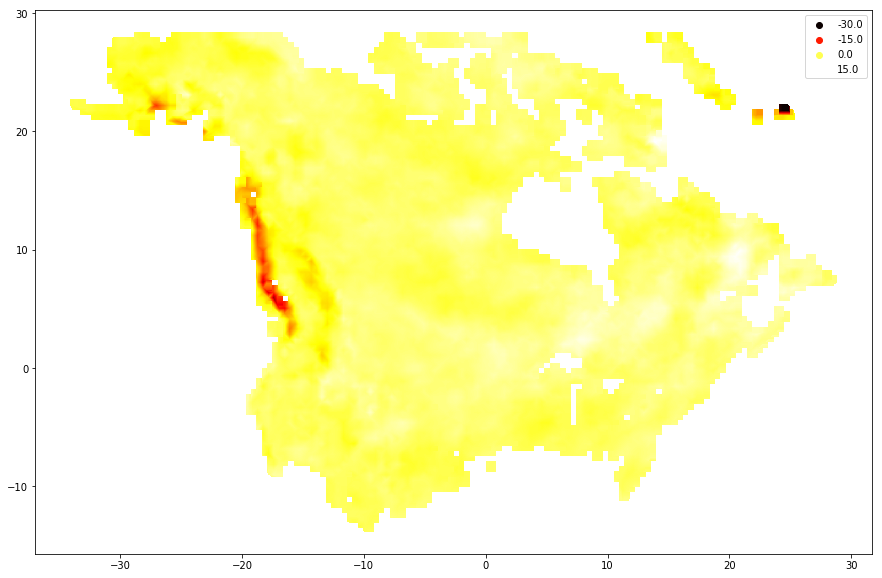

In [272]:
new_iens = iens[0, :].copy()
new_iens[master_idx] = predictions/area_relevent_grid_cells.flatten()[master_idx]
new_dv_field = new_iens.reshape((irlat.shape[0], irlon.shape[0]))

#plt.imshow(new_dv_field[imask[0, ...]])
#plt.gca().invert_yaxis()
#new_dv_field[~imask[0, ...]]



plt.figure(figsize=(15, 10))
sns.scatterplot(irlon_ens[master_idx], irlat_ens[master_idx], hue=new_iens[master_idx], marker='s', linewidth=0, palette='hot')
plt.savefig('snow')
#plt.gca().invert_yaxis()

In [33]:
df_new = pd.DataFrame({'rlat':irlat_ens[master_idx], 'rlon':irlon_ens[master_idx], 'dv':new_iens[master_idx]})
df_new.head()

,rlat,rlon,dv
0,-13.612561,-9.689375,-67.720240
1,-13.612561,-9.645631,-7.465351
2,-13.612561,-9.601886,44.473585
3,-13.612561,-9.558142,-6.339242
4,-13.612561,-9.514398,-20.212499


In [34]:
import geojson

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["rlon"],
                                                    X["rlat"],
                                                    X["dv"]))))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

#data2geojson(df_new)

In [ ]:
import folium
import json
from folium import plugins

geo_json_data = json.load(open('map1.geojson'))

# plot the density of stations
m = folium.Map([55.8781, -100], zoom_start=4)
#m.add_child(plugins.HeatMap(df_new))

# m.choropleth(geo_data='map1.geojson', data_out='data1.json', data=df_new,
#              columns=['rlat', 'rlon', 'dv'],
#              fill_color='YlOrRd', 
#              fill_opacity=0.7,
#              line_opacity=0.3)
folium.GeoJson(geo_json_data).add_to(m)
folium.LayerControl().add_to(m)

#m.create_map(path='map_1.html')
#m.save('index.html')
m

In [46]:
x = np.linspace(-10, 10)

In [47]:
y = np.linspace(-10, 10)

In [48]:
x

array([-10.        ,  -9.59183673,  -9.18367347,  -8.7755102 ,
        -8.36734694,  -7.95918367,  -7.55102041,  -7.14285714,
        -6.73469388,  -6.32653061,  -5.91836735,  -5.51020408,
        -5.10204082,  -4.69387755,  -4.28571429,  -3.87755102,
        -3.46938776,  -3.06122449,  -2.65306122,  -2.24489796,
        -1.83673469,  -1.42857143,  -1.02040816,  -0.6122449 ,
        -0.20408163,   0.20408163,   0.6122449 ,   1.02040816,
         1.42857143,   1.83673469,   2.24489796,   2.65306122,
         3.06122449,   3.46938776,   3.87755102,   4.28571429,
         4.69387755,   5.10204082,   5.51020408,   5.91836735,
         6.32653061,   6.73469388,   7.14285714,   7.55102041,
         7.95918367,   8.36734694,   8.7755102 ,   9.18367347,
         9.59183673,  10.        ])

In [52]:
x=x**2

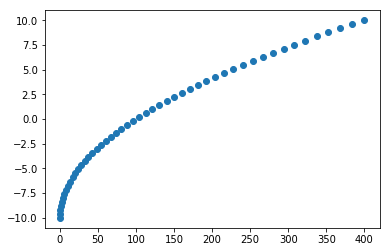

In [53]:
plt.scatter(x, y)

In [74]:
import numpy as np
from sklearn.decomposition import pca

x = np.broadcast_to(np.linspace(0., 100., 600), (35,600))
dx = np.random.random((35, 600))
y = x+dx

ymean = y - np.mean(y, axis=0)

np.mean(y, axis=0)

array([  0.56951585,   0.70857802,   0.7982587 ,   1.01130106,
         1.20463183,   1.37382622,   1.48509792,   1.68682303,
         1.80420953,   2.03887384,   2.16795803,   2.29146432,
         2.55110893,   2.66038205,   2.83326736,   3.07537037,
         3.24569924,   3.28910803,   3.51314347,   3.73649323,
         3.80233213,   3.94189815,   4.16204325,   4.41251706,
         4.48143521,   4.66680839,   4.85889294,   4.99385692,
         5.24613899,   5.3541938 ,   5.57026458,   5.66504918,
         5.87145197,   5.90515336,   6.14326233,   6.35738152,
         6.45338948,   6.67204616,   6.79925122,   6.95013163,
         7.20140629,   7.31302348,   7.61336632,   7.60899015,
         7.8373009 ,   8.08799763,   8.11307291,   8.30642722,
         8.51550386,   8.67184367,   8.81161545,   9.04155976,
         9.17615458,   9.3416874 ,   9.4756852 ,   9.70556594,
         9.85085503,  10.03431314,  10.23197511,  10.31288245,
        10.38403608,  10.6598414 ,  10.8929568 ,  11.14

In [52]:
pcan = pca.PCA(0.95).fit(y.T)
ny = pcan.transform(y.T)
ny.shape

(600, 1)

In [85]:
ny.flatten()

array([-295.4839792 , -295.00055753, -293.67859039, -292.42496631,
       -291.63438871, -291.2210919 , -289.90160546, -289.09722509,
       -287.99767757, -286.50098476, -285.98303145, -284.86091122,
       -283.86393698, -282.75980194, -281.79153402, -281.2552345 ,
       -279.73909032, -279.00504024, -278.45957808, -277.32432791,
       -275.83411637, -275.28052215, -273.8420726 , -273.40656406,
       -271.83025536, -270.92642702, -270.1188309 , -269.44617624,
       -267.81350861, -266.86154781, -266.3653959 , -265.83028362,
       -264.35265431, -263.09380203, -262.2979127 , -261.49589952,
       -260.13925597, -258.90913889, -257.77151174, -257.32989898,
       -256.72941257, -254.80603415, -254.47580545, -253.25242599,
       -252.76465085, -251.54620967, -250.64390849, -249.22618434,
       -248.44882086, -247.67027021, -245.739554  , -245.37066754,
       -244.75457332, -243.89231514, -242.49302202, -241.95996418,
       -240.47963945, -238.82399506, -238.46300467, -237.54051

In [53]:
pcam = pca.PCA(0.90).fit(ymean.T)
ymean = pcam.transform(ymean.T)
ymean.shape

(600, 29)

In [54]:
np.all(ymean==ny)

False

In [55]:
pcan.explained_variance_ratio_, np.sum(pcam.explained_variance_ratio_)

(array([0.99990191]), 0.9022452454514305)

In [58]:
np.std(pcam.components_, axis=0), np.std(ymean, axis=0)

(array([0.16802286, 0.17358607, 0.16812461, 0.16894446, 0.15550322,
        0.17160703, 0.17029338, 0.16498685, 0.15997451, 0.16021316,
        0.17083267, 0.16806482, 0.17166846, 0.16736171, 0.17147071,
        0.17828633, 0.16620434, 0.16150145, 0.17581553, 0.17768826,
        0.16910043, 0.17629938, 0.13962398, 0.15500667, 0.17164191,
        0.16805684, 0.15046774, 0.14198001, 0.15948875, 0.16243693,
        0.17238156, 0.16319307, 0.16651373, 0.17130396, 0.16734082]),
 array([0.3534444 , 0.34394183, 0.34185283, 0.33665507, 0.3295002 ,
        0.32574534, 0.3225141 , 0.31886664, 0.31697316, 0.31280194,
        0.31161466, 0.30593752, 0.30310758, 0.30094058, 0.29787265,
        0.29627436, 0.2901764 , 0.2883821 , 0.2836897 , 0.28136774,
        0.27601553, 0.27280178, 0.27140074, 0.26811372, 0.26450079,
        0.26061944, 0.25743421, 0.25088672, 0.24827672]))

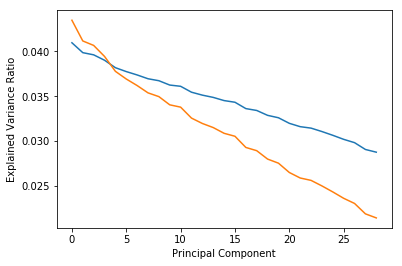

In [67]:
import matplotlib.pyplot as plt
#plt.plot(range(ymean.shape[1]), np.std(ymean, axis=0)/np.sum(np.std(ymean, axis=0)))
plt.plot(range(ymean.shape[1]), 
             pcam.explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()